In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

In [2]:
# Configurations
OLD_INDEX = ['Pclass', 'Sex', 'Age', 'UknAge', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Survived']
NEW_INDEX = ['Age', 'UknAge', 'Fare',
             'Pclass_0', 'Pclass_1', 'Pclass_2',
             'Sex_0', 'Sex_1',
             'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8',
             'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6', 'Parch_9',
             'Embarked_0', 'Embarked_1', 'Embarked_2',
             'Survived'
             ]
MAP_Sex = {'male': 0, 'female': 1}
MAP_Embarked = {'C': 0, 'Q': 1, 'S': 2}
ONE_HOT = [[1, 0], [0, 1]]
FEATURES = 26

PATH = ""

In [3]:
# 数据预处理
def preprocess(data, flag):
    # Data Cleaning
    data = pd.DataFrame(data, columns=OLD_INDEX)
    data['UknAge'] = data['UknAge'].fillna(0)
    data['Survived'] = data['Survived'].fillna(0)
    #### print(data[data['Age'].isnull()])
    data.loc[data['Age'].isnull(), 'UknAge'] = 1
    data['Age'] = data['Age'].fillna(0)
    #### print(data[data['Fare'].isnull()])
    data['Fare'] = data['Fare'].fillna(14.4)
    #### print(data[data['Embarked'].isnull()])
    data['Embarked'] = data['Embarked'].fillna('C')
    #### One-hot Encoding
    data['Pclass'] -= 1
    data['Sex'] = data['Sex'].map(MAP_Sex)
    data['Embarked'] = data['Embarked'].map(MAP_Embarked)
    data = pd.get_dummies(data, columns=['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked'])
    data = pd.DataFrame(data, columns=NEW_INDEX)
    data = data.fillna(0)
    #### Normalization
    for col in NEW_INDEX:
        pass
        maximum = data[col].max()
        if maximum > 0:
            data[col] /= maximum
    #### To List
    temp = np.array(data, dtype=np.float32)
    if flag == "train":
        x_data = torch.from_numpy(temp[:, :-1])
        y_data = torch.from_numpy(temp[:, [-1]])
        return x_data, y_data
    elif flag == "test":
        x_data = torch.from_numpy(temp[:, :-1])
        return x_data

In [4]:
# prepare the data
class TitanicDataSets(Dataset):
    def __init__(self, filepath,flag):
        xy = preprocess(pd.read_csv(filepath + "train.csv"), flag="train")

        if flag == "train":
            self.x_data = xy[0][:800]
            self.y_data = xy[1][:800]
            self.len = self.x_data.shape[0]
        if flag == "test":
            self.x_data = xy[0][800:892]
            self.y_data = xy[1][800:892]
            self.len = self.x_data.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len


train_dataset = TitanicDataSets(filepath=PATH,flag="train")
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=0)

test_dataset = TitanicDataSets(filepath=PATH,flag="test")
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False, num_workers=0)


# 构建模型
class TitanicModel(torch.nn.Module):
    def __init__(self):
        super(TitanicModel, self).__init__()
        self.linear1 = torch.nn.Linear(26, 13)
        self.linear2 = torch.nn.Linear(13, 6)
        self.linear3 = torch.nn.Linear(6, 4)
        self.linear4 = torch.nn.Linear(4, 2)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return x

titanic_model = TitanicModel()


# 构建损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=titanic_model.parameters(), lr=0.01, momentum=0.56)


# 构建循环
def train(epochs):
    for epoch in range(epochs):
        for i, data in enumerate(train_loader, 0):
            # prepare data
            inputs, labels = data
            # 前馈
            y_predict = titanic_model(inputs)
            target = torch.Tensor([x.tolist()[0] for x in labels])
            target = target.type(torch.long)
            loss = criterion(y_predict, target)
            # 反馈
            optimizer.zero_grad()
            loss.backward()
            # 更新
            optimizer.step()


def test():
    total = 0
    correct = 0
    with torch.no_grad():
        for data in test_loader:
            target = torch.Tensor([x.tolist()[0] for x in data[1]])
            outputs = titanic_model(data[0])
            _, predicted = torch.max(outputs, dim=1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    acc = 100 * correct / total
    print("acc:{}%".format(acc))
    return acc

ACC = []
EPOCH = []
for i in range(20):
    train(epochs=10)
    acc = test()
    EPOCH.append(i)
    ACC.append(acc)

plt.plot(EPOCH, ACC, ls="-.", lw=2, c="c", label="plot figure")
plt.xlabel('num of train')
plt.ylabel('loss')
plt.grid()  # 网格
plt.show()


# 输出数据
out_data = preprocess(pd.read_csv(PATH + "test.csv"), flag="test")

with torch.no_grad():
    outputs = titanic_model(out_data)
    _, predicted = torch.max(outputs, dim=1)
    submission = pd.DataFrame({'PassengerId': list(range(892, 1310)), 'Survived':predicted.tolist()})
    submission.to_csv(PATH+"submission.csv", index=0)


FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 生成示例数据
np.random.seed(0)
T = 100  # 时间序列长度
time = np.arange(0, T, 1)
temperature = 20 + 10 * np.sin(2 * np.pi * time / 365) + np.random.normal(0, 2, T)


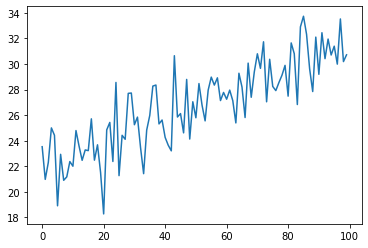

In [6]:
plt.plot(time, temperature)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math

# 生成示例数据
np.random.seed(0)
T = 100  # 时间序列长度
time = np.arange(0, T, 1)
temperature = 20 + 10 * np.sin(2 * np.pi * time / 365) + np.random.normal(0, 2, T)

# 准备数据
def prepare_data(data, seq_length):
    input_data, target = [], []
    for i in range(len(data) - seq_length):
        input_data.append(data[i:i+seq_length])
        target.append(data[i+seq_length])
    return input_data, target

# 定义序列长度和训练集大小
seq_length = 10
train_size = int(0.8 * len(temperature))

# 准备训练集和测试集数据
train_data, train_target = prepare_data(temperature[:train_size], seq_length)
test_data, test_target = prepare_data(temperature[train_size:], seq_length)

# 转换数据为PyTorch张量
train_data = torch.tensor(train_data).float()
train_target = torch.tensor(train_target).float()
test_data = torch.tensor(test_data).float()
test_target = torch.tensor(test_target).float()

# 定义位置编码器
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len):
        super(PositionalEncoder, self).__init__()
        self.d_model = d_model
        
        # 计算位置编码矩阵
        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x * math.sqrt(self.d_model)
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len]
        return x

# 定义Transformer模型
class TransformerModel(nn.Module):
    def __init__(self, d_model, max_seq_len, num_heads, num_layers):
        super(TransformerModel, self).__init__()
        self.position_encoder = PositionalEncoder(d_model, max_seq_len)
        
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers
        )
        
        self.fc = nn.Linear(d_model, 1)
    
    def forward(self, x):
        x = self.position_encoder(x)
        x = self.transformer(x, x)
        x = x[:, -1, :]  # 只使用最后一个时间步的输出
        x = self.fc(x)
        return x

# 定义模型参数
d_model = 32
max_seq_len = seq_length
num_heads = 4
num_layers = 2

# 创建模
model = TransformerModel(d_model, max_seq_len, num_heads, num_layers)

<ipython-input-7-083590aa339e>:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  train_data = torch.tensor(train_data).float()


In [8]:
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
batch_size = 150
# 迭代训练数据
num_epochs = 10
for epoch in range(num_epochs):
    # 在每个epoch之前初始化损失累计
    total_loss = 0.0
    
    for i in range(0, len(train_data), batch_size):
        # 获取一个batch的训练数据
        batch_inputs = train_data[i:i+batch_size]
        batch_labels = train_target[i:i+batch_size]
        
        # 清零梯度
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(batch_inputs)
        
        # 计算损失
        loss = criterion(outputs, batch_labels)
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        
        # 累计损失
        total_loss += loss.item()
    
    # 打印每个epoch的平均损失
    avg_loss = total_loss / (len(train_data) // batch_size)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

RuntimeError: The size of tensor a (10) must match the size of tensor b (32) at non-singleton dimension 2

In [9]:
train_data.shape

torch.Size([70, 10])

In [10]:
train_target.shape

torch.Size([70])